# Question 2: NLP Dataset - Sentiment140

## 1 Import Libraries/Dataset

### a. Import required libraries

In [ ]:
# Import necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras import regularizers
import nltk
from nltk.corpus import stopwords
import re
import time
nltk.download('stopwords')

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
% matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### b. Import the dataset

In [ ]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

In [ ]:
file = '/content/drive/My Drive/Colab Notebooks/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(file, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

In [ ]:
# Changing class 4 to 1 to use binary cross-entropy divergence function
df['target'] = df.target.map({4:1,0:0})

### c. Check the GPU available

In [ ]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2 Data Visualization
** Shape of the train and test data is printed in section 3.

In [ ]:
# Print 2 tweets for Sentiment class 0

for i, row in df.loc[df.target == 0, :].head(2).iterrows():
  print(row['text'])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [ ]:
# Print 2 tweets for Sentiment class 4 (changed to 1)

for i, row in df.loc[df.target == 1, :].head(2).iterrows():
  print(row['text'])

I LOVE @Health4UandPets u guys r the best!! 
im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!


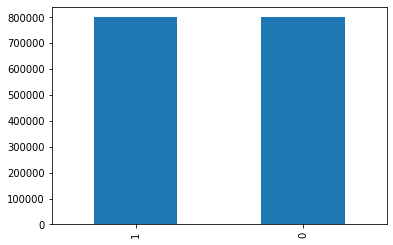

In [ ]:
# Plot class distribution in for each target value
df.target.value_counts().plot(kind='bar')

## 3 Data Preprocessing

In [ ]:
data=df.iloc[:,-1].values
label=df.iloc[:,0].values

Cleaning the text to improve the quality of data

In [ ]:
def tweet_clean(tweet):
    tweet=re.sub(r'@[A-Za-z0-9]+'," ",tweet) ##Removing the usernames
    tweet=re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet) ##Removing digits and punctuations
    tweet=re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet) ## removing links
    tweet=re.sub(r' +'," ",tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"can't", "cannot ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r"\'scuse", " excuse ", tweet)
    tweet = tweet.strip(' ')
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('-',' ')
    tweet = tweet.replace("’", "'").replace("′", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")
    tweet = tweet.replace("€", " euro ").replace("'ll", " will")
    tweet = tweet.replace("don't", "do not").replace("didn't", "did not").replace("im","i am").replace("it's", "it is")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    tweet = re.sub('\s+', ' ', tweet)
    tweet=tweet.split()

    tweet=' '.join(word for word in tweet)

    return tweet.lower()

text_clean=[tweet_clean(text) for text in data]
df['text']=text_clean

In [ ]:
# Split training and test dataset
x_col = ['text']
y_col = ['target']

X_train, X_test, y_train, y_test = train_test_split(df[x_col], df[y_col], train_size=TRAIN_SIZE, random_state=40)

print(f"Training data shape is {X_train.shape}")
print(f"Testing data shape is {X_test.shape}")

Training data shape is (1280000, 1)
Testing data shape is (320000, 1)


In [ ]:
# Use pretrained word-embeddings to convert the text into word vectors
test_embeddings = embed(X_test['text'].values.tolist())
train_embeddings = embed(X_train['text'].values.tolist())

## 4 Model Building

* We have  used 3 dense layers with optimum number of hidden nodes after experimenting with various combinations and choosing the one with maximum accuracy.
* L2 regularization is added to all the layers.
* Added droput layer after layer 2 based on trials at different positions and picking the one with maximum accuracy.

In [ ]:
start_time = time.time()

model = keras.models.Sequential()

model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001),input_shape=train_embeddings.shape[1:]))
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 18,657
Trainable params: 18,657
Non-trainable params: 0
_________________________________________________________________


## 5 Model Compilation
* We are using the Adam optimizer because it combines the benefit of AdaGrad and RMSProp. Adam is also an adaptive gradient descent algorithm, such that it maintains a learning rate per-parameter. 
* We are using the learning rate value as 0.01. The higher learning rates have tendency to overshoot and miss the minima whereas too small learning rate takes too many steps to reach the minima.

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

## 6 Model Training

In [ ]:
start_time = time.time()
history = model.fit(train_embeddings, y_train, epochs = 25, batch_size=10000, validation_split=0.1)
print(f" Total training time is {time.time() - start_time} seconds")

Epoch 1/25
116/116 [==============================] - 1s 9ms/step - loss: 0.5986 - accuracy: 0.7106 - val_loss: 0.5983 - val_accuracy: 0.6953
Epoch 2/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5631 - accuracy: 0.7268 - val_loss: 0.5556 - val_accuracy: 0.7322
Epoch 3/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5564 - accuracy: 0.7311 - val_loss: 0.5550 - val_accuracy: 0.7311
Epoch 4/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5543 - accuracy: 0.7320 - val_loss: 0.5507 - val_accuracy: 0.7337
Epoch 5/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5524 - accuracy: 0.7332 - val_loss: 0.5496 - val_accuracy: 0.7348
Epoch 6/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5496 - accuracy: 0.7349 - val_loss: 0.5489 - val_accuracy: 0.7354
Epoch 7/25
116/116 [==============================] - 1s 8ms/step - loss: 0.5489 - accuracy: 0.7346 - val_loss: 0.5460 - val_accuracy: 0.7365
Epoch 

## 7 Model Evaluation

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.5422173738479614
Final training accuracy  0.737637996673584


In [ ]:
print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy ', history.history['val_accuracy'][-1])

Final Validation loss 	 0.5466596484184265
Final Validation accuracy  0.7340234518051147


In [ ]:
testLoss, testAccuracy = model.evaluate( test_embeddings, y_test)

10000/10000 [==============================] - 20s 2ms/step - loss: 0.5461 - accuracy: 0.7334


In [ ]:
y_pred = model.predict_classes(test_embeddings)
y_true = y_test # np.argmax(y_test, axis=1)
print(classification_report(y_pred, y_true))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0       0.80      0.70      0.75    182429
           1       0.66      0.77      0.71    137571

    accuracy                           0.73    320000
   macro avg       0.73      0.74      0.73    320000
weighted avg       0.74      0.73      0.73    320000



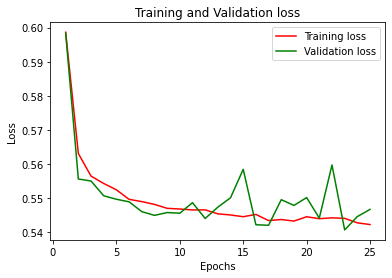

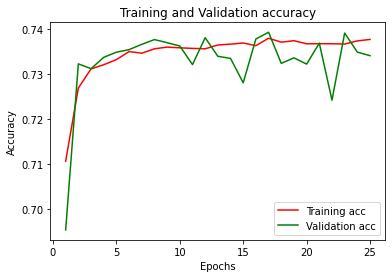

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(confusion_matrix(y_pred, y_true))

[[128504  53925]
 [ 31381 106190]]


# Hyperparameters Tuning

## Model 2 - Changing network depth

### Model Building

In [ ]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001),input_shape=train_embeddings.shape[1:]))
model_2.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_2.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_2.add(layers.Dropout(0.2))

model_2.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_2.add(keras.layers.Dense(1, activation = 'sigmoid'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 13,553
Trainable params: 13,553
Non-trainable params: 0
__________________________________________________

### Model Compilation

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Model Training

In [ ]:
start_time = time.time()

history = model_2.fit(train_embeddings, y_train, epochs = 25, batch_size=10000, validation_split=0.2)

print(f" Total training time is {time.time() - start_time} seconds")

Epoch 1/25
103/103 [==============================] - 1s 11ms/step - loss: 0.6056 - accuracy: 0.7030 - val_loss: 0.5680 - val_accuracy: 0.7233
Epoch 2/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5660 - accuracy: 0.7239 - val_loss: 0.5641 - val_accuracy: 0.7244
Epoch 3/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5588 - accuracy: 0.7289 - val_loss: 0.5573 - val_accuracy: 0.7284
Epoch 4/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5565 - accuracy: 0.7305 - val_loss: 0.5575 - val_accuracy: 0.7276
Epoch 5/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5544 - accuracy: 0.7317 - val_loss: 0.5503 - val_accuracy: 0.7344
Epoch 6/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5525 - accuracy: 0.7324 - val_loss: 0.5568 - val_accuracy: 0.7284
Epoch 7/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5525 - accuracy: 0.7324 - val_loss: 0.5515 - val_accuracy: 0.7315
Epoch

### Model Evaluation

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.5460317730903625
Final training accuracy  0.734201192855835


In [ ]:
print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy ', history.history['val_accuracy'][-1])

Final Validation loss 	 0.5448998808860779
Final Validation accuracy  0.7343242168426514


In [ ]:
testLoss, testAccuracy = model_2.evaluate( test_embeddings, y_test)

10000/10000 [==============================] - 21s 2ms/step - loss: 0.5444 - accuracy: 0.7349


In [ ]:
y_pred = model_2.predict_classes(test_embeddings)
y_true = y_test
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73    149918
           1       0.77      0.72      0.74    170082

    accuracy                           0.73    320000
   macro avg       0.73      0.74      0.73    320000
weighted avg       0.74      0.73      0.74    320000



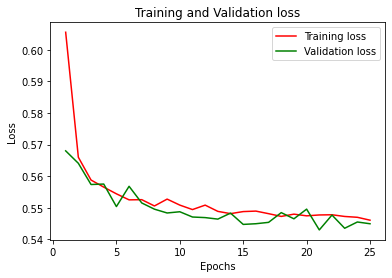

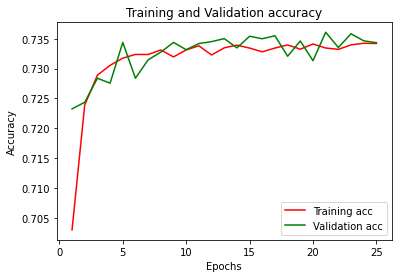

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(confusion_matrix(y_pred, y_true))

[[112479  37439]
 [ 47406 122676]]


## Model 3 - Changing Optimiser

### Model Building

In [ ]:
model_3 = keras.models.Sequential()

model_3.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001),input_shape=train_embeddings.shape[1:]))
model_3.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_3.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_3.add(layers.Dropout(0.2))

model_3.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), activity_regularizer=regularizers.l2(0.001)))
model_3.add(keras.layers.Dense(1, activation = 'sigmoid'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 13,553
Trainable params: 13,553
Non-trainable params: 0
__________________________________________________

### Model Compilation

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.01)
model_3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Model Training

In [ ]:
start_time = time.time()
history = model_3.fit(train_embeddings, y_train, epochs = 25, batch_size=10000, validation_split=0.2)

print(f" Total training time is {time.time() - start_time} seconds")

Epoch 1/25
103/103 [==============================] - 1s 12ms/step - loss: 0.6377 - accuracy: 0.6709 - val_loss: 0.5949 - val_accuracy: 0.7054
Epoch 2/25
103/103 [==============================] - 1s 9ms/step - loss: 0.6018 - accuracy: 0.6995 - val_loss: 0.5810 - val_accuracy: 0.7158
Epoch 3/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5967 - accuracy: 0.7026 - val_loss: 0.5948 - val_accuracy: 0.6985
Epoch 4/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5934 - accuracy: 0.7041 - val_loss: 0.5880 - val_accuracy: 0.7081
Epoch 5/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5914 - accuracy: 0.7050 - val_loss: 0.5795 - val_accuracy: 0.7162
Epoch 6/25
103/103 [==============================] - 1s 10ms/step - loss: 0.5908 - accuracy: 0.7065 - val_loss: 0.5789 - val_accuracy: 0.7147
Epoch 7/25
103/103 [==============================] - 1s 9ms/step - loss: 0.5898 - accuracy: 0.7072 - val_loss: 0.5901 - val_accuracy: 0.7093
Epoc

### Model Evaluation

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss 	 0.5845367312431335
Final training accuracy  0.7093769311904907


In [ ]:
print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy ', history.history['val_accuracy'][-1])

Final Validation loss 	 0.5738159418106079
Final Validation accuracy  0.7157655954360962


In [ ]:
testLoss, testAccuracy = model_3.evaluate( test_embeddings, y_test)

10000/10000 [==============================] - 20s 2ms/step - loss: 0.5727 - accuracy: 0.7167


In [ ]:
y_pred = model_3.predict_classes(test_embeddings)
y_true = y_test
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73    178274
           1       0.66      0.75      0.70    141726

    accuracy                           0.72    320000
   macro avg       0.72      0.72      0.72    320000
weighted avg       0.72      0.72      0.72    320000



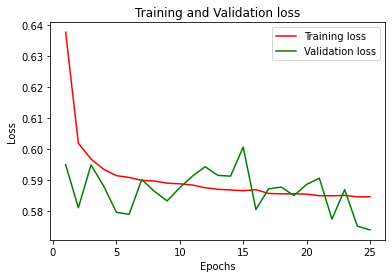

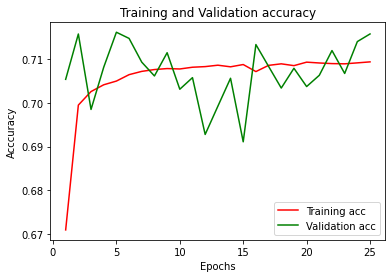

In [ ]:
# plotting training and validation loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acccuracy')
plt.legend()
plt.show()

In [ ]:
print(confusion_matrix(y_pred, y_true))

[[123759  54515]
 [ 36126 105600]]


# Comparison 
Adding additional hidden layer with different set of hidden nodes dosen't seem to be impacting the accuracy of the model. Changing the optimizer from Adam to RMSProp decreases the accuracy of the model. The state of the art accuracy for this dataset is in the range of 86%.